<a href="https://colab.research.google.com/github/scgupta/yearn2learn/blob/master/ml/pandas/pandas_apply_fn_on_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>How to Efficently Apply a Function to Pandas Dataframe Rows</center></h1>

<p><center>
<address>&copy; Satish Chandra Gupta<br/>
LinkedIn: <a href="https://www.linkedin.com/in/scgupta/">scgupta</a>,
Twitter: <a href="https://twitter.com/scgupta">scgupta</a>
</address> 
</center></p>

---
Blog post: [Best Way to Apply a Function to Each Row in Pandas DataFrame](https://medium.com/@scgupta/apply-function-to-pandas-dataframe-rows-76df74165ee4)

Applying a function to all rows in a Pandas DataFrame is one of the most common operations during data wrangling. Pandas DataFrame apply function is the most obvious choice for doing it. It takes a function as an argument and applies it along an axis of the DataFrame. However, it is not always the best choice.

In this notebook, you will explore various alternatives. You will measure, compare, and plot their performances.

## Problem

Given a dataframe with each row representing a task, categorize each task using the [Eisenhower Method](https://en.wikipedia.org/wiki/Time_management#The_Eisenhower_Method) into 4 buckets based on their imporance and urgency:

- Important and Urgent: **Do** right away
- Important but not Urgent: **Schedule** for later
- Not Important but Urgent: **Delegate** to someone else
- Neither Important nor Urgent: **Delete** time wasters.

<center>
<img src="https://miro.medium.com/max/575/1*_44gqprR6NYVRn38zgo9vA.jpeg" />
</center>


---
## Environment Setup

We will try several alternatives. Install needed libs and import the modules.

In [1]:
!pip install \
    datetime pandas numpy \
    faker line_profiler perfplot \
    numba pandarallel dask[dataframe] swifter \
    gpustat \
    &> /dev/null

In [2]:
%load_ext line_profiler

In [3]:
import numpy as np
import pandas as pd
import datetime
import perfplot

from faker import Faker

In [4]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [5]:
import multiprocessing

CPU_COUNT = multiprocessing.cpu_count()

CPU_COUNT

2

In [6]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [7]:
!gpustat -cp

Error on querying NVIDIA devices. Use --debug flag for details


---

## Generate Test Data

In real life, this data would be read from a CSV file or a data store. But for this tutorial, let's generate the test data to keep it simple.

In [8]:
def generate_test_data(size: int, days: int = 30):
  fake = Faker()
  Faker.seed(42)

  PRIORITIES = {
    0: 'HIGH',
    1: 'MEDIUM',
    2: 'LOW'
  }

  return pd.DataFrame({
    'task_name': [
      f'Task {i + 1}'
      for i in range(size)
    ],
    'due_date': [
      fake.date_between(start_date='today', end_date=f'+{days}d')
      for _ in range(size)
    ],
    'priority': [
      PRIORITIES[fake.pyint(min_value=0, max_value=(len(PRIORITIES) - 1))]
      for i in range(size)
    ]
  })


In [9]:
# Try generate_test_data
tmp_df = generate_test_data(10, 5)
tmp_df.info()
tmp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   task_name  10 non-null     object
 1   due_date   10 non-null     object
 2   priority   10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


,task_name,due_date,priority
0,Task 1,2022-02-22,LOW
1,Task 2,2022-02-19,LOW
2,Task 3,2022-02-19,LOW
3,Task 4,2022-02-23,HIGH
4,Task 5,2022-02-20,LOW
5,Task 6,2022-02-20,MEDIUM
6,Task 7,2022-02-20,HIGH
7,Task 8,2022-02-19,HIGH
8,Task 9,2022-02-23,HIGH
9,Task 10,2022-02-19,HIGH


In [10]:
tmp_df['task_name'].loc[0]

'Task 1'

In [11]:
tmp_df['due_date'].loc[0]
# pd.to_datetime(tmp_df['due_date']).dt.date.loc[0]

datetime.date(2022, 2, 22)

In [12]:
tmp_df['priority'].loc[0]

'LOW'

### Generate Dataset

In [13]:
K_MAX = 21

In [14]:
# Generate a million rows. Use sample from it to create various size data sets
# Will take some time as Faker will be called sequencially.
test_data_set = generate_test_data(1 + 2 ** K_MAX, 30)

In [15]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2022-02-24,LOW
1,Task 2,2022-02-20,HIGH
2,Task 3,2022-03-04,MEDIUM
3,Task 4,2022-03-02,LOW
4,Task 5,2022-03-01,HIGH


In [16]:
def test_data_sample(size: int):
  return test_data_set.sample(n=size).copy().reset_index(drop=True)

In [17]:
# Test sample of size 10
test_data_sample(10).head(5)

,task_name,due_date,priority
0,Task 1378271,2022-02-26,LOW
1,Task 509777,2022-03-07,LOW
2,Task 284259,2022-03-16,LOW
3,Task 1441642,2022-02-28,MEDIUM
4,Task 1209702,2022-03-02,LOW


In [18]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2022-02-24,LOW
1,Task 2,2022-02-20,HIGH
2,Task 3,2022-03-04,MEDIUM
3,Task 4,2022-03-02,LOW
4,Task 5,2022-03-01,HIGH


---
## Optimize DataFrame Storage

Compacting the data not only saves space, but also speeds up the processing. Two common opportunities are:

- Converting timestamp strings or datetime to [datetime64](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- Converting strings of enum types to [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) data type

For fair comparision, compression test data to max extent possible.

In [19]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097153 entries, 0 to 2097152
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   task_name  object
 1   due_date   object
 2   priority   object
dtypes: object(3)
memory usage: 48.0+ MB


In [20]:
priority_dtype = pd.api.types.CategoricalDtype(
  categories=['LOW', 'MEDIUM', 'HIGH'],
  ordered=True
)

In [21]:
priority_map = dict(enumerate(pd.Series(['']).astype(priority_dtype).cat.categories))
priority_map

{0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [22]:
test_data_set['priority'] = test_data_set['priority'].astype(priority_dtype)
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097153 entries, 0 to 2097152
Data columns (total 3 columns):
 #   Column     Dtype   
---  ------     -----   
 0   task_name  object  
 1   due_date   object  
 2   priority   category
dtypes: category(1), object(2)
memory usage: 34.0+ MB


In [23]:
test_data_set['priority'].loc[0]

'LOW'

Using category for priority reduced the memory usage by ~30%.

---

## Functions for The Eisenhower Method

Decide about action needed using [Eisenhower method](https://en.wikipedia.org/wiki/Time_management#The_Eisenhower_Method):

| Important | Urgent    | Binary | Int | Action   |
| --------- | --------- | :----: | :-: | -------- |
| True (1)  | True (1)  |   11   |  3  | DO       |
| True (1)  | False (0) |   10   |  2  | SCHEDULE |
| False (0) | True (1)  |   01   |  1  | DELEGATE |
| False (0) | False (0) |   00   |  0  | DELETE   |

In [24]:
action_dtype = pd.api.types.CategoricalDtype(
  categories=['DELETE', 'DELEGATE', 'SCHEDULE', 'DO'],
  ordered=True
)

In [25]:
action_map = dict(enumerate(pd.Series(['']).astype(action_dtype).cat.categories))
action_map

{0: 'DELETE', 1: 'DELEGATE', 2: 'SCHEDULE', 3: 'DO'}

In [26]:
def eisenhower_action(is_important: bool, is_urgent: bool) -> int:
  return 2 * is_important + is_urgent

def eisenhower_action_str(is_important: bool, is_urgent: bool) -> str:
  return action_map[eisenhower_action(is_important, is_urgent)]

In [27]:
# Let's say anything due by tomorrow is Urgent
cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

In [28]:
# Test compute_eisenhower_action

eisenhower_action_str(
  test_data_set.loc[0].priority == 'HIGH',
  test_data_set.loc[0].due_date <= cutoff_date
)

'DELETE'

---

## Experiment with Different Alternatives

In the rest of the notebook, we will evaluate various alternatives for applying `eisenhower_action` function to DataFrame rows. First, you will measure the time for a sample of 100k rows. Then, you will measure and plot the time for up to a million rows.

<center>
<img src="https://miro.medium.com/max/700/1*jQ6Z3Yqm84fyiSME_2P8Bw.jpeg" />
</center>

In [29]:
# Work with a smaller data set to try each alternative
data_sample = test_data_sample(100000)

### Method 1: Loop Over All Rows of a DataFrame

In [30]:
def loop_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

  result = []
  for i in range(len(df)):
    row = df.iloc[i]
    result.append(
      eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    )

  return pd.Series(result)

In [31]:
%timeit data_sample['action_loop'] = loop_impl(data_sample)

1 loop, best of 5: 30.1 s per loop


In [32]:
%lprun -f loop_impl  loop_impl(test_data_sample(100))

### Method 2: Iterate over rows with `iterrows` Function

In [33]:
def iterrows_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for index, row in df.iterrows()
  )

In [34]:
%timeit data_sample['action_iterrow'] = iterrows_impl(data_sample)

1 loop, best of 5: 6.25 s per loop


### Method 3: Iterate over rows with `itertuples` Function

In [35]:
def itertuples_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for row in df.itertuples()
  )

In [36]:
%timeit data_sample['action_itertuples'] = itertuples_impl(data_sample)

1 loop, best of 5: 209 ms per loop


### Method 4: Pandas `apply` Function to Every Row

In [37]:
def apply_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

In [38]:
%timeit data_sample['action_impl'] = apply_impl(data_sample)

1 loop, best of 5: 2.12 s per loop


### Method 5: List Comprehension

In [39]:
def list_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series([
    eisenhower_action(priority == 'HIGH', due_date <= cutoff_date)
    for (priority, due_date) in zip(df['priority'], df['due_date'])
  ])

In [40]:
%timeit data_sample['action_list'] = list_impl(data_sample)

10 loops, best of 5: 91.8 ms per loop


### Method 6: Python `map` Function

In [41]:
def map_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(map(eisenhower_action, df['priority'] == 'HIGH', df['due_date'] <= cutoff_date))

In [42]:
%timeit data_sample['action_map'] = map_impl(data_sample)

10 loops, best of 5: 82.1 ms per loop


### Method 7: *Vectorization*

In [43]:
def vec_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return (2*(df['priority'] == 'HIGH') + (df['due_date'] <= cutoff_date))

In [44]:
%timeit data_sample['action_vec'] = vec_impl(data_sample)

10 loops, best of 5: 18.3 ms per loop


### Method 8: NumPy `vectorize` function

Ref.: [From Python to NumPy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)

In [45]:
def np_vec_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return np.vectorize(eisenhower_action)(df['priority'] == 'HIGH', df['due_date'] <= cutoff_date)

In [46]:
%timeit data_sample['action_np_vec'] = np_vec_impl(data_sample)

10 loops, best of 5: 36.7 ms per loop


### Method 9: Numba Decorators

[Numba](https://numba.pydata.org) is commonly used to speed up applying mathmatical functions.

In [47]:
import numba

@numba.vectorize
def numba_eisenhower_action(is_important: bool, is_urgent: bool) -> int:
  return 2 * is_important + is_urgent

def numba_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return numba_eisenhower_action(
    (df['priority'] == 'HIGH').to_numpy(),
    (df['due_date'] <= cutoff_date).to_numpy()
  )

In [48]:
%timeit data_sample['action_numba'] = numba_impl(data_sample)

The slowest run took 11.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 23.7 ms per loop


### Method 10: Multiprocessing with `pandarallel` 

In [49]:
from pandarallel import pandarallel

pandarallel.initialize()

def pandarallel_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.parallel_apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [50]:
%timeit data_sample['action_pandarallel'] = pandarallel_impl(data_sample)

1 loop, best of 5: 2.52 s per loop


### Method 11: Parallelize with Dask

[Dask](https://dask.org) is a parallel computing library that supports scaling up NumPy, Pandas, Scikit-learn and many other Python libraries.


In [51]:
import dask.dataframe as dd

def dask_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return dd.from_pandas(df, npartitions=CPU_COUNT).apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1,
    meta=(int)
  ).compute()

In [52]:
%timeit data_sample['action_dask'] = dask_impl(data_sample)

1 loop, best of 5: 2.41 s per loop


### Method 12: Opportunistic Parallelization with Swifter

[Swifter](https://github.com/jmcarpenter2/swifter) automatically decides which is faster: to use dask parallel processing or a simple pandas apply.

In [53]:
import swifter

def swifter_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.swifter.apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

In [54]:
%timeit data_sample['action_swifter'] = swifter_impl(data_sample)

10 loops, best of 5: 25.8 ms per loop


### Test Correctness

If any of the results from following cells are having rows, then there has been a mistake.

In [55]:
data_sample[data_sample['action_loop'] != data_sample['action_iterrow']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [56]:
data_sample[data_sample['action_loop'] != data_sample['action_itertuples']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [57]:
data_sample[data_sample['action_loop'] != data_sample['action_impl']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [58]:
data_sample[data_sample['action_loop'] != data_sample['action_list']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [59]:
data_sample[data_sample['action_loop'] != data_sample['action_map']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [60]:
data_sample[data_sample['action_loop'] != data_sample['action_vec']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [61]:
data_sample[data_sample['action_loop'] != data_sample['action_np_vec']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [62]:
data_sample[data_sample['action_loop'] != data_sample['action_numba']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [63]:
data_sample[data_sample['action_loop'] != data_sample['action_pandarallel']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [64]:
data_sample[data_sample['action_loop'] != data_sample['action_dask']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [65]:
data_sample[data_sample['action_loop'] != data_sample['action_swifter']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_map,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


---

## Plot Performance Over DataFrame Size


Overall ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Kernels ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:30

(0.00012984300000000006, 302.83922957500016)


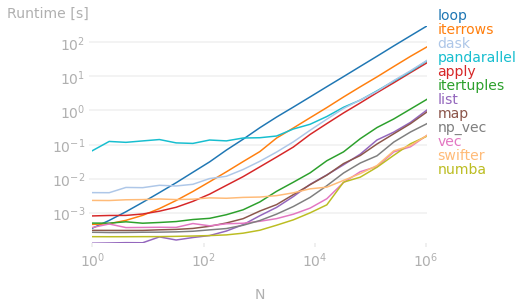

In [66]:
kernels = [
  loop_impl,
  iterrows_impl,
  itertuples_impl,
  apply_impl,
  list_impl,
  map_impl,
  vec_impl,
  np_vec_impl,
  numba_impl,
  pandarallel_impl,
  dask_impl,
  swifter_impl
]

labels = [str(k.__name__)[:-5] for k in kernels]

perfplot.show(
  setup=lambda n: test_data_sample(n),
  kernels=kernels,
  labels=labels,
  n_range=[2**k for k in range(K_MAX)],
  xlabel='N',
  logx=True,
  logy=True,
  #equality_check=None
)

## Summary

Performance Comparision:

| Method             | CPU Time (s) | GPU Time (s) |
| ------------------ | -----------: | -----------: |
| Python Loop        |    56.600000 |    48.300000 |
| Pandas iterrow()   |     9.040000 |     7.550000 |
| Pandas apply()     |     1.850000 |     1.540000 |
| Pandas itertuples()|     0.211000 |     0.162000 |
| List Comprehension |     0.078400 |     0.051800 |
| Python Map         |     0.071500 |     0.053900 |
| NumPy vectorize()  |     0.035700 |     0.019500 |
| Vectorization      |     0.020000 |     0.007920 |
| ------------------ | ------------ | ------------ |
| Pandarallel        |     2.270000 |     1.870000 |
| Dask               |     2.130000 |     1.750000 |
| Swifter            |     0.022900 |     0.010700 |
| Numba              |     0.018900 |     0.006960 |

---
<p>Copyright &copy 2020 - 2022 <a href="https://www.linkedin.com/in/scgupta">Satish Chandra Gupta</a>.</p>
<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png" align="left"/> <p>&nbsp;<a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC BY-NC-SA 4.0 International</a> License.</p>